**DBA 4714 Group Project**
-

## Importing relevant packages

In [1]:
import pandas as pd 
import numpy as np
from scipy.stats import chi2_contingency, randint, uniform
from IPython.display import display

# data viz modules
import matplotlib.pyplot as plt
import seaborn as sns

# model modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# ignore warning
import warnings
warnings.filterwarnings("ignore")

# multiprocessing
import multiprocessing
from joblib import Parallel, delayed

## Data Cleaning

In [2]:
# reading data in
df = pd.read_csv('hotel_bookings.csv')

### Removing agents and company columns

Rationale: Knowing the agent and company is not useful since there is no other information about the agents and company available in the dataset. There are also many NULLs in the columns which could make the analysis inaccurate. Both reservation_status_date and reservation_status are also irrelevant to our modelling.

In [3]:
# removing agents and company columns
df = df.drop(columns=['agent', 'company', 'reservation_status_date', 'reservation_status'])

### Removing NULL values

In [4]:
# counting the number of nulls
null_count = df.isna().sum()
nulls = null_count[null_count > 0]

nulls

children      4
country     488
dtype: int64

In [5]:
# removing the nulls since total null rows is only about 0.4% of total rows
# removing the nulls should not affect our analysis
df = df.dropna().reset_index(drop = True)

### Rearranging columns

In [6]:
# rearranging is_cancelled as the last column
column_to_move = 'is_canceled'
df = df[[col for col in df if col != column_to_move] + [column_to_move]]

In [7]:
# ensuring all dtypes are correct
df['arrival_date_year'] = df['arrival_date_year'].astype('object')

In [8]:
# making a copy of cleaned data
data = df.copy()

## Exploratory Data Analysis (EDA)

In [9]:
# ensuring dtypes of columns are correct before correlation/association analysis
is_repeated_guest_map = {0: 'No', 1: 'Yes'}
data['is_repeated_guest'] = data['is_repeated_guest'].map(is_repeated_guest_map)

### Correlation Analysis of Numeric Variables

In [10]:
# making a copy of data and changing dtype of is_canceled
df1 = data.copy()
is_canceled_map = {0: 'No', 1: 'Yes'}
df1['is_canceled'] = df1['is_canceled'].map(is_canceled_map)

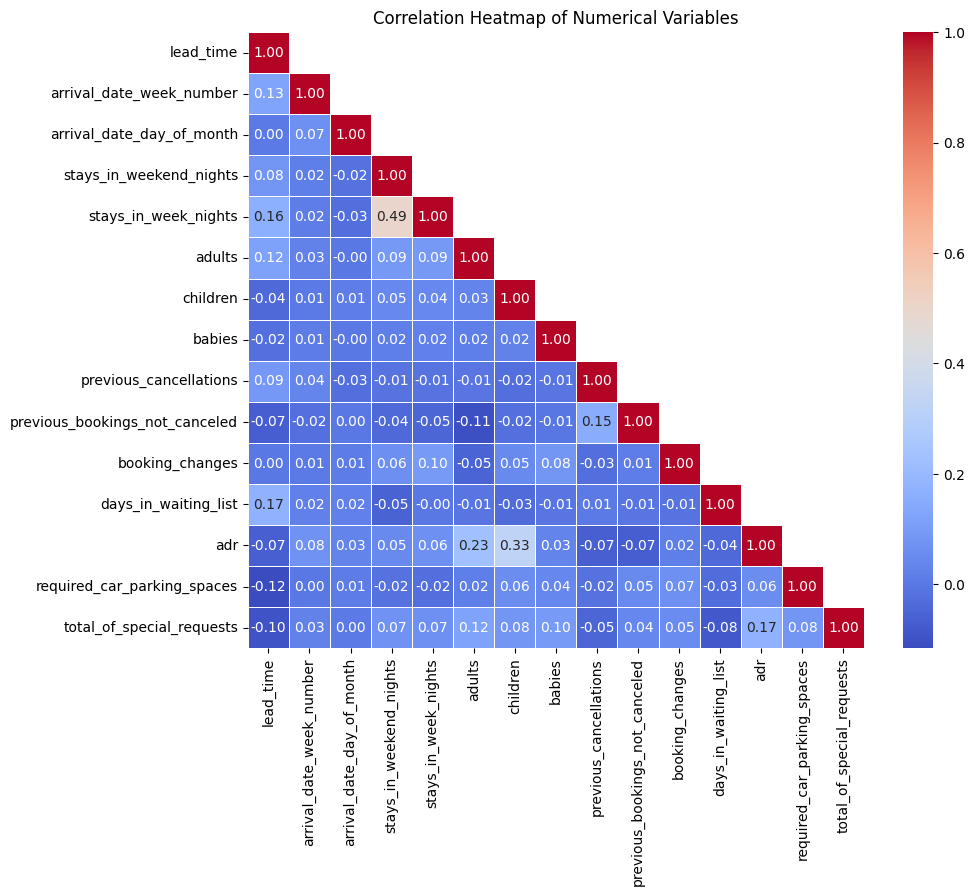

In [11]:
numeric_df = df1.select_dtypes(include=[np.number])

# getting the correlation matrix
correlation_matrix = numeric_df.corr()

# plotting the heatmap of the correlation
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool), k = 1)
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5, mask = mask, square = True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

### Association analysis between categorical variables

In [12]:
cat_var = df1.select_dtypes(include = ['object', 'category'])

# Create a list of variable pairs
variable_pairs = [(x, y) for i, x in enumerate(cat_var.columns) for j, y in enumerate(cat_var.columns) if i < j]

# Create empty lists for results
results = []

# Loop through each variable pair
for pair in variable_pairs:
    # Create a contingency table
    contingency_table = pd.crosstab(cat_var[pair[0]], cat_var[pair[1]])
    
    # Calculate the chi-squared test statistic, p-value, degrees of freedom, and expected table
    chi2_stat, p_val, dof, expected_table = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V for dependent variable pairs
    n = contingency_table.sum().sum()
    phi2 = chi2_stat / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = round(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), 3)
    
    # Append results to the list
    results.append([pair[0], pair[1], cramers_v])

# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns = ['Variable 1', 'Variable 2', "Cramer's V"])

In [13]:
# getting the highly correlated pairs
# arbitrary threshold for high correlation
threshold = 0.3
highly_correlated_pairs = results_df[results_df["Cramer's V"] >= threshold]
highly_correlated_pairs = highly_correlated_pairs.sort_values(by = "Cramer's V", ascending = False).reset_index(drop = True)

highly_correlated_pairs

,Variable 1,Variable 2,Cramer's V
0,reserved_room_type,assigned_room_type,0.778
1,market_segment,distribution_channel,0.614
2,deposit_type,is_canceled,0.481
3,arrival_date_year,arrival_date_month,0.428
4,hotel,assigned_room_type,0.391
5,market_segment,deposit_type,0.374
6,country,is_canceled,0.358
7,market_segment,is_repeated_guest,0.353
8,hotel,reserved_room_type,0.325
9,hotel,meal,0.318


### Visualisations/Graphs

#### Pie Chart Showing Proportion of is_cancelled 

In [14]:
df2 = data.copy()

# Combine the columns into a single datetime column
df2['arrival_date'] = pd.to_datetime(df2['arrival_date_year'].astype(str) + '-' 
                                      + df2['arrival_date_month'].astype(str)+ '-' 
                                      + df2['arrival_date_day_of_month'].astype(str))

df2['month_year'] = pd.to_datetime(df2['arrival_date_year'].astype(str) + '-' 
                                      + df2['arrival_date_month'].astype(str))

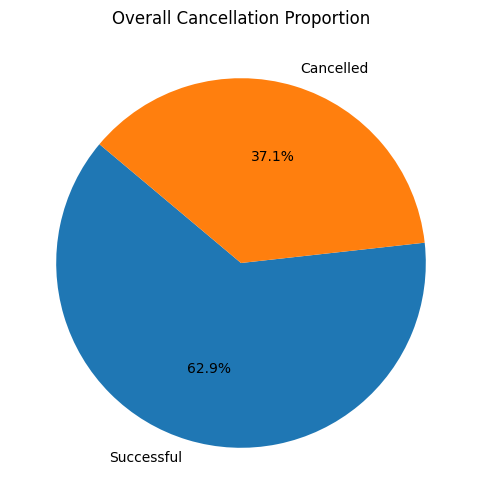

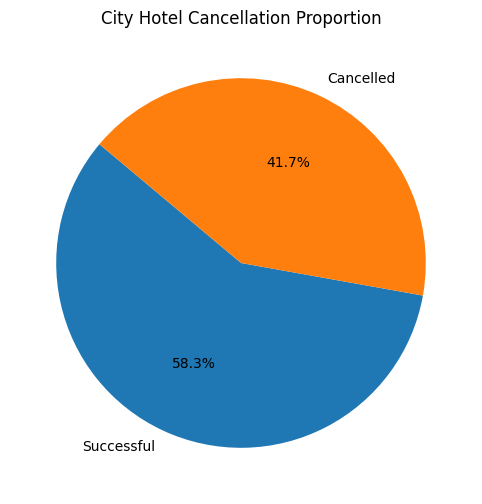

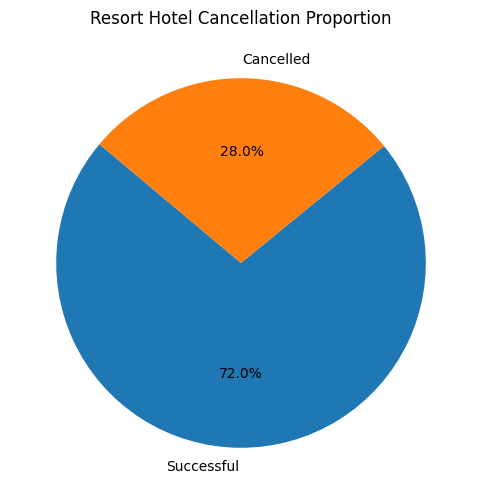

In [15]:
# pie chart to show proportion of is_cancelled

# Calculate the overall cancellation rate
cancelled_counts = df2['is_canceled'].value_counts()
cancelled_proportion = cancelled_counts / cancelled_counts.sum()

# Plot overall cancellation pie chart
plt.figure(figsize=(8, 6))
plt.pie(cancelled_proportion, labels=["Successful", "Cancelled"], autopct = '%1.1f%%', startangle = 140)
plt.title('Overall Cancellation Proportion')
plt.show()

# Create separate pie charts for <City Hotel> and <Rural Hotel>
for hotel_type in ['City Hotel', 'Resort Hotel']:
    hotel_data = df2[df2['hotel'] == hotel_type]
    cancelled_counts = hotel_data['is_canceled'].value_counts()
    cancelled_proportion = cancelled_counts / cancelled_counts.sum()
    
    # Plot pie chart for each hotel type
    plt.figure(figsize = (8, 6))
    plt.pie(cancelled_proportion, labels = ["Successful", "Cancelled"], autopct = '%1.1f%%', startangle = 140)
    plt.title(f'{hotel_type} Cancellation Proportion')
    plt.show()

#### Time-series showing guest bookings over time

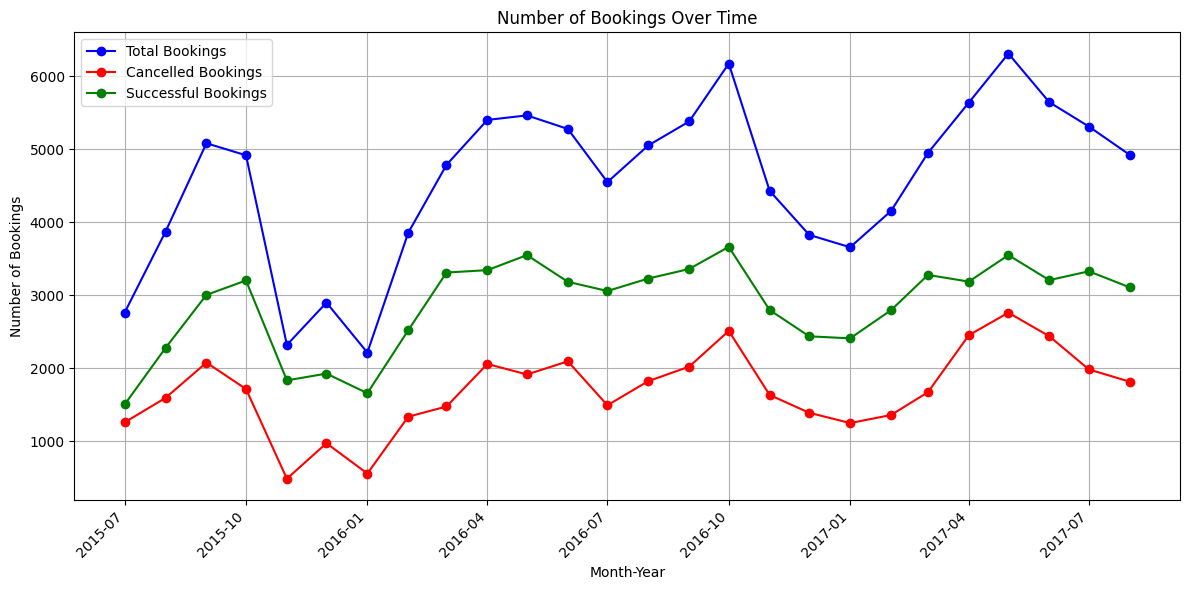

In [16]:
# Group the data by month-year and is_canceled, then count the number of bookings
grouped_data = df2.groupby(['month_year', 'is_canceled']).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize = (12, 6))

# Total bookings line
plt.plot(grouped_data.index, grouped_data[0] + grouped_data[1], label = 'Total Bookings', marker = 'o', color = 'blue')

# Cancelled bookings line
plt.plot(grouped_data.index, grouped_data[1], label = 'Cancelled Bookings', marker = 'o', color = 'red')

# Successful bookings line
plt.plot(grouped_data.index, grouped_data[0], label = 'Successful Bookings', marker = 'o', color = 'green')

# Labeling and styling
plt.title('Number of Bookings Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Bookings')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


#### Month-on-month change in cancellation rates

posx and posy should be finite values
posx and posy should be finite values


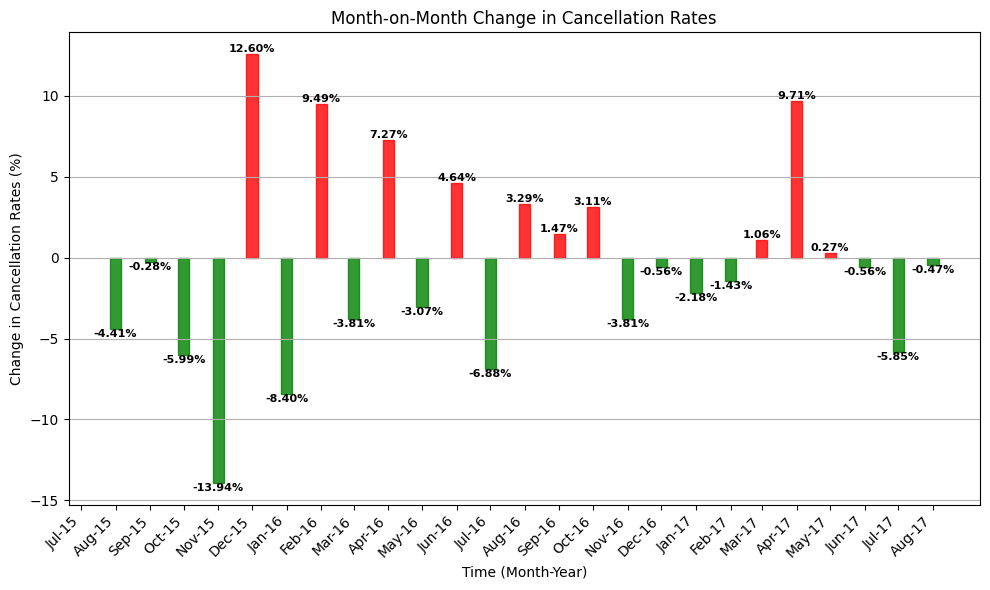

In [17]:
# Group the data by the new datetime column and is_canceled, then count the number of bookings
grouped_data = df2.groupby(['month_year', 'is_canceled'], observed=False).size().unstack(fill_value=0)

# Calculate cancellation rates for each month
cancellation_rates = grouped_data[1] / (grouped_data[0] + grouped_data[1]) * 100

# Calculate month-on-month change in cancellation rates
month_on_month_change = cancellation_rates.diff()

# Plot the data
plt.figure(figsize=(10, 6))

# Bar chart for month-on-month change in cancellation rates
mom_change = plt.bar(month_on_month_change.index, month_on_month_change, alpha=0.8, width=10)

# Change color based on the value
for bar in mom_change:
    if bar.get_height() <= 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

for bar in mom_change:
    height = bar.get_height()
    if height >= 0:
        pos='bottom'
    else:
        pos='top'
    plt.text(bar.get_x() + bar.get_width()/2., height, '{:.2f}%'.format(height), ha='center', 
             va=pos, fontsize=8, fontweight='bold')

# Labeling and styling
plt.title('Month-on-Month Change in Cancellation Rates')
plt.xlabel('Time (Month-Year)')
plt.ylabel('Change in Cancellation Rates (%)')
plt.xticks(ticks=month_on_month_change.index, 
           labels=month_on_month_change.index.strftime("%b-%y"), 
           rotation=45, ha='right')
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

#### Number of Repeat Bookings Over Times to Gauge Quality of Service

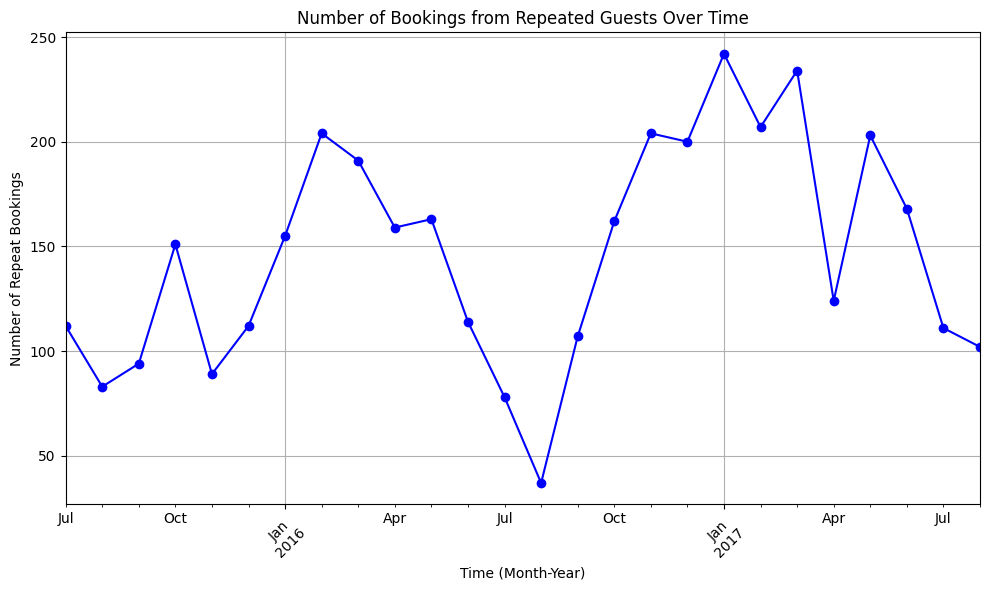

In [18]:
# Filter data for repeated guests (is_repeated_guest = 1)
repeated_guests_df = df2[df2['is_repeated_guest'] == 'Yes']

# Group by month_year and count the number of bookings
bookings_per_month = repeated_guests_df.groupby('month_year')['is_canceled'].count()

# Plot the line graph
plt.figure(figsize=(10, 6))
bookings_per_month.plot(kind='line', marker='o', color='b', linestyle='-')
plt.title('Number of Bookings from Repeated Guests Over Time')
plt.xlabel('Time (Month-Year)')
plt.ylabel('Number of Repeat Bookings')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Customer Bookings Over Time to Identify Seasonalities

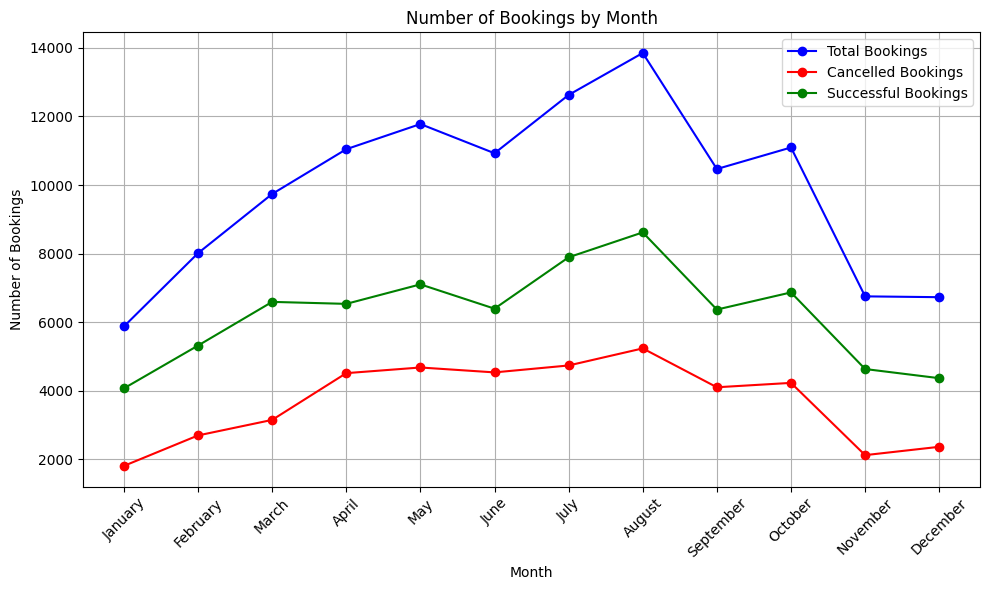

In [19]:
# Convert arrival_date_month to categorical for proper ordering
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df2['arrival_date_month'] = pd.Categorical(df2['arrival_date_month'], categories=months_order, ordered=True)

# Group the data by arrival_date_month and is_canceled, then count the number of bookings
grouped_data = df2.groupby(['arrival_date_month', 'is_canceled'], observed=False).size().unstack(fill_value=0)

# Plot the data
plt.figure(figsize=(10, 6))

# Total bookings line
plt.plot(grouped_data.index, grouped_data[0] + grouped_data[1], label='Total Bookings', marker='o', color='blue')

# Cancelled bookings line
plt.plot(grouped_data.index, grouped_data[1], label='Cancelled Bookings', marker='o', color='red')

# Successful bookings line
plt.plot(grouped_data.index, grouped_data[0], label='Successful Bookings', marker='o', color='green')

# Labeling and styling
plt.title('Number of Bookings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


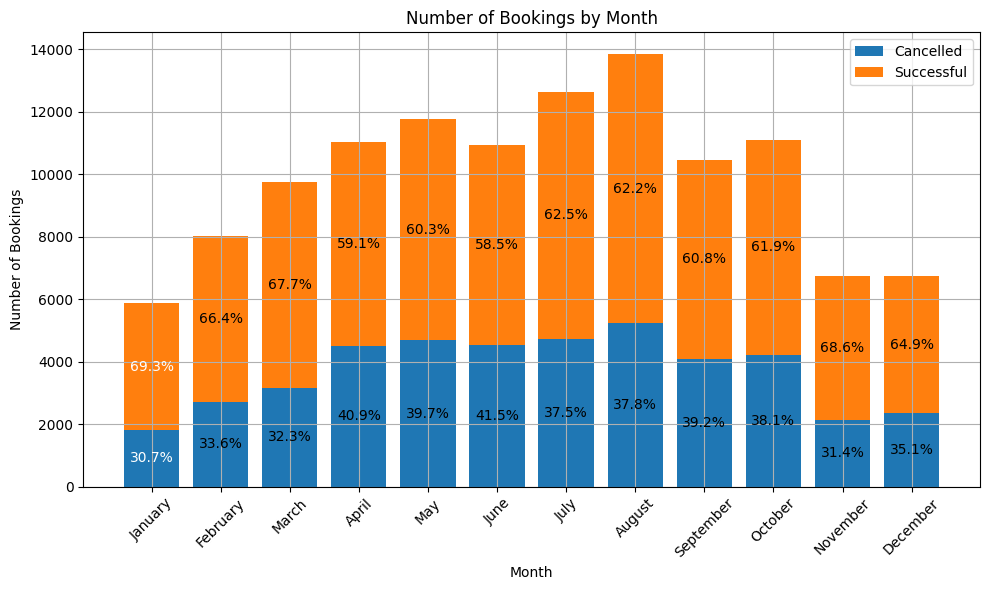

In [20]:
# Convert arrival_date_month to categorical for proper ordering
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df2['arrival_date_month'] = pd.Categorical(df2['arrival_date_month'], categories=months_order, ordered=True)

# Group the data by arrival_date_month and is_canceled, then count the number of bookings
grouped_data = df2.groupby(['arrival_date_month', 'is_canceled'], observed=False).size().unstack(fill_value=0)

# Calculate the percentage of bookings where is_canceled = True
cancelled_percentage = (grouped_data[1] / (grouped_data[1] + grouped_data[0])) * 100
success_percentage = 100-cancelled_percentage

# Plot the data
plt.figure(figsize=(10, 6))

# Stacked bar chart
bottom = None
for status in [1, 0]:
    plt.bar(grouped_data.index, grouped_data[status], label='Cancelled' if status else 'Successful', bottom=bottom)
    if bottom is None:
        bottom = grouped_data[status]
        # Annotate each bar with the percentage of bookings where is_canceled = True
        for j, val in enumerate(grouped_data[status]):
            plt.text(j, bottom[j] - val/2, f"{cancelled_percentage[j]:.1f}%", ha='center', va='center', color='white' if j == 0 else 'black')

    else:
        bottom += grouped_data[status]
        for j, val in enumerate(grouped_data[status]):
                    plt.text(j, bottom[j] - val/2, f"{success_percentage[j]:.1f}%", ha='center', va='center', color='white' if j == 0 else 'black')

# Labeling and styling
plt.title('Number of Bookings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

#### Cancellation Rates and Deposit Types

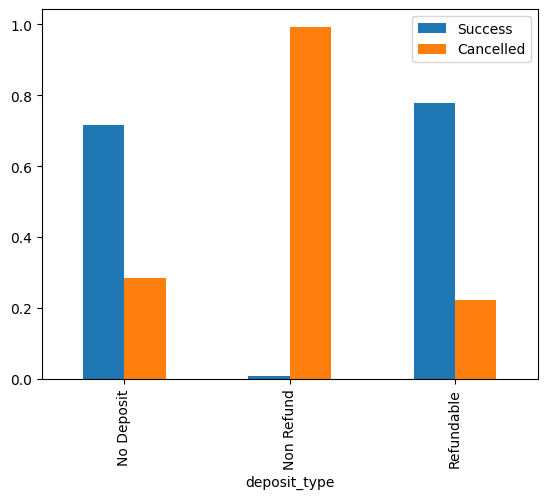

In [21]:
df2.groupby(['deposit_type'], observed=False)["is_canceled"].value_counts(normalize=True).unstack(fill_value=0).plot(kind="bar")

plt.legend(labels=["Success", "Cancelled"])
plt.show()

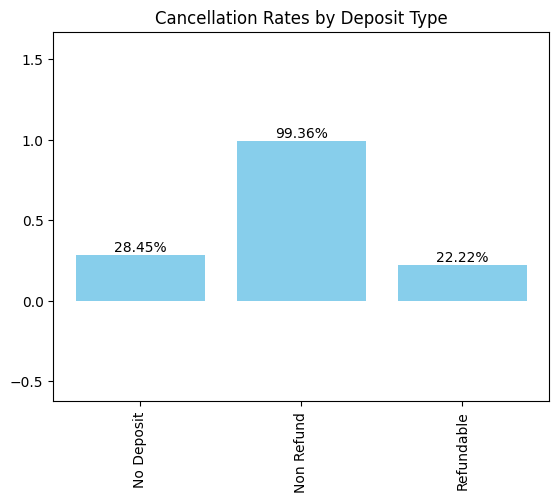

In [22]:
# Group the data by deposit_type and is_canceled, then count the number of bookings
grouped_data = df2.groupby(['deposit_type', 'is_canceled']).size().unstack(fill_value=0)

# Calculate cancellation rates for each deposit_type
cancellation_rates = grouped_data[1] / grouped_data.sum(axis=1)

cr_dt = plt.bar(x=cancellation_rates.index, height=cancellation_rates, color="skyblue", bottom = 0)

for bar in cr_dt.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()*100:.2f}%', ha='center', va='bottom')

plt.title('Cancellation Rates by Deposit Type')

# Show plot
plt.xticks(rotation=90)
plt.axis('equal')
plt.show()

#### Number of Bookings by Deposit Type to understand why refundable bookings have such high cancellation rate

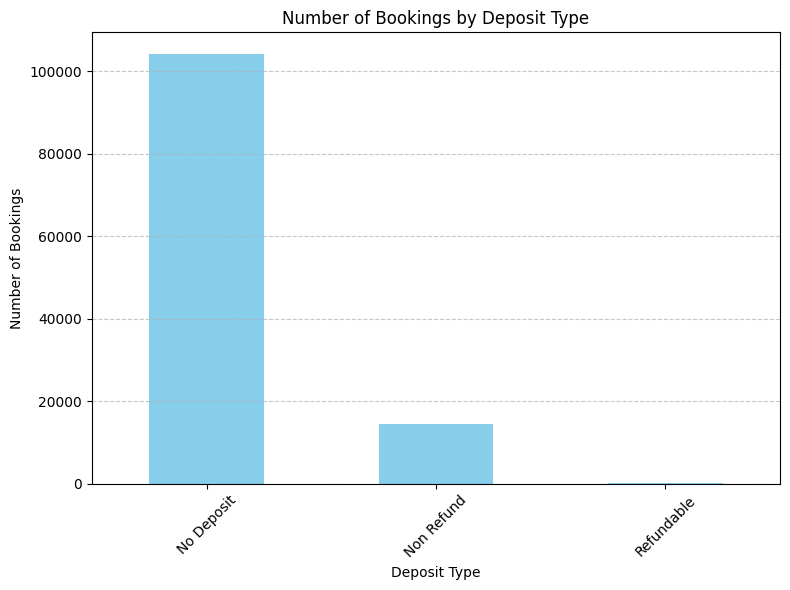

In [23]:
# Count the number of bookings for each deposit type
deposit_type_counts = df2['deposit_type'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
deposit_type_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Bookings by Deposit Type')
plt.xlabel('Deposit Type')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
# number of bookings by deposit types
pd.DataFrame(deposit_type_counts)

,count
deposit_type,
No Deposit,104163
Non Refund,14573
Refundable,162


#### Lead time vs cancellation

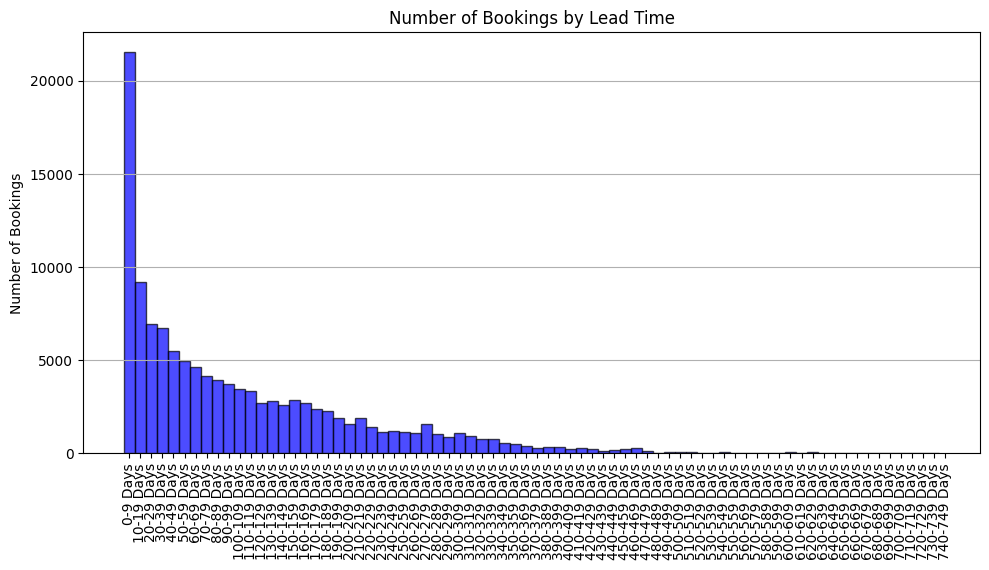

In [25]:
# Calculate cancellation rates
df2['cancellation_rate'] = df2['is_canceled'].mean() * 100

# Plot the histogram
plt.figure(figsize=(10, 6))
histo_lt = plt.hist(df2['lead_time'], bins=range(0, max(df2['lead_time']) + 10, 10), color='blue', alpha=0.7, edgecolor='black')

plt.xticks(ticks=range(5, max(df2['lead_time']) + 10, 10), 
           labels=[f'{x}-{x+9} Days' for x in range(0, max(df2['lead_time'])+10, 10)], rotation=90)

# Labeling and styling and showing plot
plt.title('Number of Bookings by Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Number of Bookings')
plt.grid(axis='y')
plt.tight_layout()

plt.xlabel("")
plt.show()

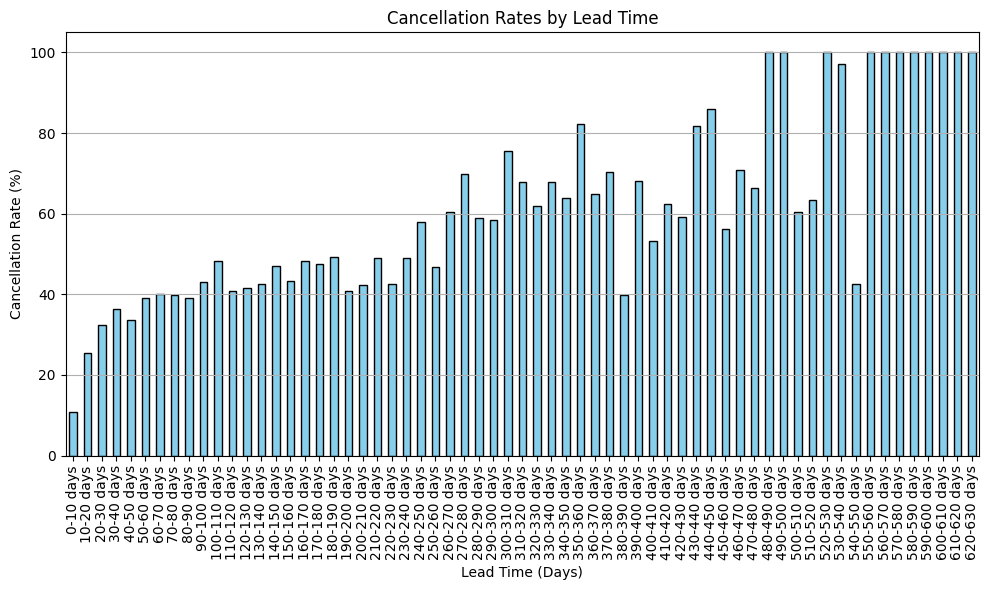

In [26]:
# Group lead times into bins of size 10
lead_time_bins = pd.cut(df2['lead_time'], bins=range(0, df2[df2['is_canceled'] == 1]['lead_time'].max() + 11, 10), right=False)

# Calculate cancellation rates for each lead time bin
cancellation_rates_by_lead_time = df2.groupby(lead_time_bins)['is_canceled'].value_counts(normalize=True).mul(100).unstack(fill_value=0)[1]

cancellation_rates_by_lead_time
# Plot the data
plt.figure(figsize=(10, 6))
bars = cancellation_rates_by_lead_time.plot(kind='bar', color='skyblue', edgecolor='black')

# Labeling and styling
plt.title('Cancellation Rates by Lead Time')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Cancellation Rate (%)')

# Label the bins
plt.xticks(range(len(cancellation_rates_by_lead_time.index)), [f'{interval.left}-{interval.right} days' for interval in cancellation_rates_by_lead_time.index], rotation=90)

plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()


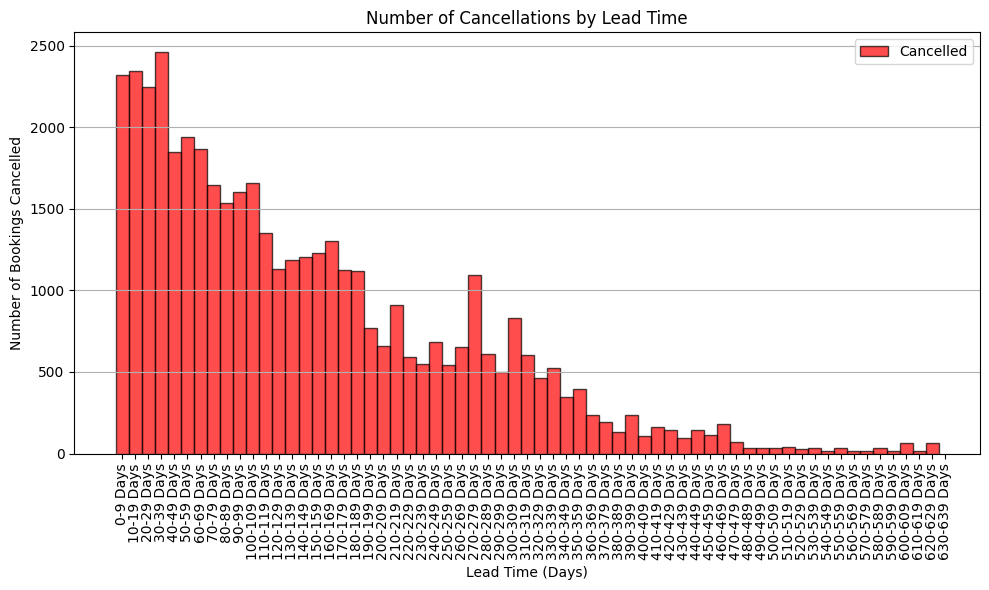

In [27]:
# Calculate cancellation rates
df2['cancellation_rate'] = df2['is_canceled'].mean() * 100

# Plot the histogram
plt.figure(figsize=(10, 6))
histo_lt = plt.hist(df2[df2['is_canceled'] == 1]['lead_time'], bins=range(0, max(df2[df2['is_canceled'] == 1]['lead_time']) + 10, 10), color='red', alpha=0.7, label='Cancelled', edgecolor='black')

plt.xticks(ticks=range(5, max(df2[df2['is_canceled'] == 1]['lead_time']) + 10, 10), 
           labels=[f'{x}-{x+9} Days' for x in range(0, max(df2[df2['is_canceled'] == 1]['lead_time'])+10, 10)], rotation=90)

# Labeling and styling and showing plot
plt.title('Number of Cancellations by Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Number of Bookings Cancelled')
plt.xlabel('Lead Time (Days)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

### Clustering to find customer segments

1. Normalise numerical data
2. use K-prototype clustering (K-means cant account for categorical variables)
3. use elbow plot to determine K
4. Feature importance### Clustering to find customer segments

In [28]:
# Dropping is_cancelled since it is the target variable
df3 = data.drop(columns = ['is_canceled'])

# Select numerical and categorical columns
numerical_cols = df3.select_dtypes(include = np.number).columns.tolist()
categorical_cols = df3.select_dtypes(include = ['object', 'category']).columns.tolist()

# Normalize numerical data
# scaler = StandardScaler()
scaler = MinMaxScaler()
df3[numerical_cols] = scaler.fit_transform(df3[numerical_cols])

# Extract positional indices of numerical columns
numerical_cols_index = [df3.columns.get_loc(col) for col in numerical_cols]

# Extract positional indices of categorical columns
categorical_cols_index = [df3.columns.get_loc(col) for col in categorical_cols]

****
Warning: The code below takes quite some time to run (about 1.5 hours).

In [29]:
max_clusters = 6

# Function to compute cost for a given number of clusters
def compute_cost(num_clusters):
    kproto = KPrototypes(n_clusters = num_clusters, init = 'Huang')
    kproto.fit(df3, categorical = categorical_cols_index)
    return np.sum(kproto.cost_)

# Use parallel computation
cost = Parallel(n_jobs = -1)(delayed(compute_cost)(num_clusters) for num_clusters in range(1, max_clusters + 1))

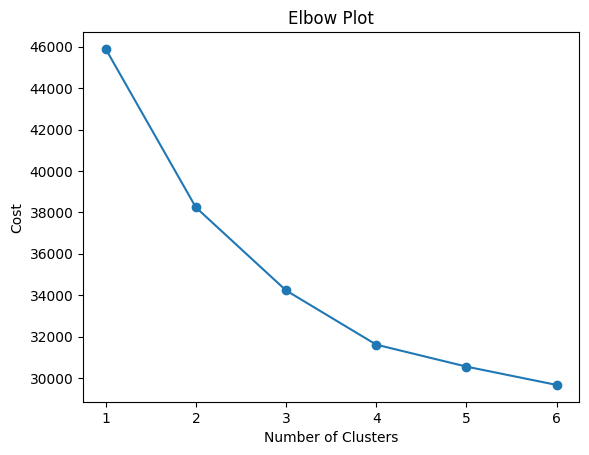

In [30]:
# Plot the Elbow plot
plt.plot(range(1, max_clusters + 1), cost, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Plot')
plt.show()

#### Fitting the new model with hyperparameter, K

In [31]:
chosen_k = 4

# Use K-prototype clustering with the chosen number of clusters
kproto = KPrototypes(n_clusters = chosen_k, init='Huang')
clusters = kproto.fit_predict(df3, categorical = categorical_cols_index)

****

#### Table with the centroids of each feature

Note: Need to double check if the meaning behind each value is like importance table. According to chatgpt, it represents the average value of that feature in the cluster. Means can see it like feature importance table

In [32]:
# Get the list of column names from the original data
original_column_order = df3.columns.tolist()

# Saving cluster centroids into df
centroid_df = pd.DataFrame(kproto.cluster_centroids_, columns = numerical_cols + categorical_cols)

# Sorting columns like original data
cluster_centroids_sorted = centroid_df.reindex(columns = original_column_order)

# Inverse transform numerical columns of cluster centroids after sorting
sorted_cluster_centroids_numerical = scaler.inverse_transform(cluster_centroids_sorted[numerical_cols].values)

# Combine sorted numerical and categorical cluster centroids into a DataFrame
sorted_cluster_centroids = np.hstack((sorted_cluster_centroids_numerical, cluster_centroids_sorted[categorical_cols].values))
sorted_centroid_df = pd.DataFrame(sorted_cluster_centroids, columns = numerical_cols + categorical_cols)


In [33]:
sorted_centroid_df[numerical_cols]

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,76.880186,13.218686,7.999172,0.899353,2.472038,1.83499,0.085739,0.006034,0.041292,0.195654,0.216832,1.788216,93.212183,0.06042,0.563062
1,124.00397,36.247068,8.187059,0.965237,2.619548,1.882164,0.110835,0.009426,0.167935,0.087195,0.214123,2.051008,107.182452,0.062343,0.583149
2,95.446949,16.507994,22.832519,0.885537,2.360818,1.822485,0.097906,0.006255,0.038768,0.157814,0.219494,2.586667,99.081873,0.05974,0.511239
3,114.451535,39.325993,23.592477,0.95651,2.538514,1.887181,0.118495,0.009592,0.085283,0.100975,0.234022,2.831098,106.549761,0.064696,0.625428


In [34]:
#Average values of each group for categorical features
sorted_centroid_df[categorical_cols]

,hotel,arrival_date_year,arrival_date_month,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,customer_type
0,City Hotel,2017,April,BB,PRT,Online TA,TA/TO,No,A,A,No Deposit,Transient
1,City Hotel,2016,August,BB,PRT,Online TA,TA/TO,No,A,A,No Deposit,Transient
2,City Hotel,2017,May,BB,PRT,Online TA,TA/TO,No,A,A,No Deposit,Transient
3,City Hotel,2016,August,BB,PRT,Online TA,TA/TO,No,A,A,No Deposit,Transient


In [35]:
# appending clusters to original dataset
df3['cluster'] = clusters

In [36]:
# Renaming the clusters according to Perplexity's suggestions
cluster_map = {0: 'Long-Stay', 1: 'Short-Stay Leisure', 2: 'Families', 3: 'Business'}
df3['cluster'] = df3['cluster'].map(cluster_map)

In [37]:
# Inversing the scaling
df3[numerical_cols] = scaler.inverse_transform(df3[numerical_cols])

In [38]:
# Appending is_canceled to clustered data
df3['is_canceled'] = data['is_canceled']

In [39]:
# Saving the dataset
# df3.to_csv('clustered_data.csv', index = False)

### Loading saved data with clusters

In [40]:
df4 = pd.read_csv('clustered_data.csv')

**Model 1: Neural Network**
-

In [41]:
# Load the dataset
df_nn = df4.copy()

X_nn = df_nn.drop('is_canceled', axis = 1)
y_nn = df_nn['is_canceled']

# Identify categorical and numerical columns
categorical_cols = []
numerical_cols = []
for col in X_nn.columns:
    if X_nn[col].dtype == 'O':
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

# Preprocessing: Encode categorical variables with OneHotEncoder and scale numerical variables with StandardScaler
preprocessor = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols)
    ])

# Split the data into training and testing sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size = 0.2, random_state = 42)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train_nn)
X_test_preprocessed = preprocessor.transform(X_test_nn)

# Define the neural network architecture
model_nn = Sequential([
    Dense(64, activation = 'relu', input_shape = (X_train_preprocessed.shape[1],)),
    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(32, activation = 'relu'),
    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(1, activation = 'sigmoid')
])

# Compile the model
model_nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['auc'])

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True, verbose = 1)

# Train the model
history = model_nn.fit(X_train_preprocessed, y_train_nn, epochs = 50, batch_size = 64, validation_split = 0.2, callbacks = [early_stopping])

# Evaluate the nn using ROC AUC on the testing data
y_pred_proba = model_nn.predict(X_test_preprocessed).ravel()
roc_auc = roc_auc_score(y_test_nn, y_pred_proba)
print("ROC AUC:", roc_auc)

Epoch 1/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - auc: 0.7824 - loss: 0.5067 - val_auc: 0.9017 - val_loss: 0.3790
Epoch 2/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - auc: 0.8914 - loss: 0.3842 - val_auc: 0.9122 - val_loss: 0.3491
Epoch 3/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - auc: 0.9020 - loss: 0.3658 - val_auc: 0.9156 - val_loss: 0.3431
Epoch 4/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - auc: 0.9054 - loss: 0.3608 - val_auc: 0.9173 - val_loss: 0.3397
Epoch 5/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - auc: 0.9116 - loss: 0.3496 - val_auc: 0.9217 - val_loss: 0.3328
Epoch 6/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - auc: 0.9129 - loss: 0.3478 - val_auc: 0.9226 - val_loss: 0.3306
Epoch 7/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - auc: 0.9171 - loss: 0.3407 - val_auc: 0.9257 - val_loss: 0.3237
Epoch 8/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step - auc: 0.9167 - loss: 0.3395 - val_auc: 0.9260 - val_loss: 0.3222
Epoch 9/50
1189/1189 ━━━━━

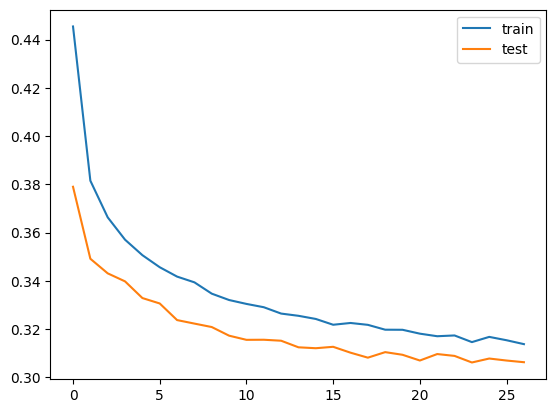

In [42]:
# plotting the train and validation loss
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [43]:
# Get the weights of the first layer (input layer)
input_layer_weights = model_nn.layers[0].get_weights()[0]

# Get the feature names after one-hot encoding
feature_names_categorical = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features = categorical_cols)
feature_names_numerical = numerical_cols

# Concatenate categorical and numerical feature names
feature_names = np.concatenate((feature_names_categorical, feature_names_numerical))

# Calculate feature importance as the absolute sum of weights for each feature
feature_importance = np.abs(input_layer_weights).sum(axis = 1)

**Model 2: Extreme Gradient Boosting (XGB) Classifier**
-

In [44]:
# helper function for cross validation
def show_cv_results(model, X, y):
    scores = cross_validate(model, X, y, cv = 10, return_train_score = True, scoring = 'roc_auc')
    print(f"Mean Train Score: {scores['train_score'].mean()}")
    print(f"Mean Test Score: {scores['test_score'].mean()}")

    display(pd.DataFrame(scores))

In [45]:
# Helper function to score model before tuning threshold value
# Threshold value set to default
def score_model(model, x, y):
    pred = model.predict(x)
    auc = roc_auc_score(y, pred)
        
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index = columns, columns = columns)
    ax = sns.heatmap(df_cm, cmap = 'Oranges', annot = True, fmt = 'g', 
                     xticklabels = ['Successful', 'Canceled'], 
                     yticklabels = ['Successful', 'Canceled'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    print(f'AUC before threshold tuning is {round(auc, 3)}.')

In [46]:
# Define the loss caluclation function
def calculate_loss(conf_matrix):
    cost_TP = 0 # True Positive
    cost_FP = 50 # False Positive 
    cost_FN = 100 # False Negative
    cost_TN = 0 # True Negative 

    costs = np.array([[cost_TN, cost_FP], [cost_FN, cost_TP]])

    return np.sum(conf_matrix * costs)

In [47]:
# Evaluation Metrics for models
def get_EvalMetrics(model, x, y):

    ###########
    # Function to get relevant evaluation metrics.
    # Input: model is the classifier, X is the X_test, Y is Y_test.
    # Output: Intersection threshold, AUC, Recall and F1-score.
    # Intersection refers to the intersection between AUC and Recall curves.
    # Intersection allow for maximisation of both AUC and Recall.
    # If model is NN, the global variable y_pred_proba from NN above will be used.
    ###########

    thresholds = np.linspace(0, 1, 500)
    recall_values = []
    auc_values = []

    for threshold in thresholds:

        if model is model_nn:
            y_pred = (y_pred_proba > threshold).astype(int)
        
        else:
            y_pred = (model.predict_proba(x)[:, 1] >= threshold).astype(int)
        
        recall = recall_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)

        recall_values.append(recall)
        auc_values.append(auc)
        
    # Find the point where recall and AUC intersect
    # idx is determined when the sign of the difference between recall and auc changes
    idx = np.argwhere(np.diff(np.sign(np.array(recall_values) - np.array(auc_values)))).flatten()
    intersection_idx = idx[0]

    # Plotting intersection point
    intersection_threshold = thresholds[intersection_idx]
    intersection_recall = recall_values[intersection_idx]
    intersection_auc = auc_values[intersection_idx]

    # Plotting Metric vs Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, recall_values, label='Recall', color='blue')
    plt.plot(thresholds, auc_values, label='AUC', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Threshold vs Metric')
    plt.legend()
    plt.grid(True)

    # Plotting intersection point
    plt.plot(intersection_threshold, intersection_auc, 'ro')

    # Plot vertical and horizontal dotted lines
    plt.plot([intersection_threshold, intersection_threshold], [0, intersection_recall], 'r--', lw=1)
    plt.plot([0, intersection_threshold], [intersection_recall, intersection_recall], 'r--', lw=1)

    # Label the intersection point
    offset = 0.02
    plt.text(intersection_threshold + offset, intersection_recall + offset, f'Threshold: {round(intersection_threshold, 3)}\nRecall: {round(intersection_recall, 3)}\nAUC: {round(intersection_auc, 3)}', fontsize=8)

    # Set x-axis and y-axis limits
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.show()

    # Plotting confusion matrix after determining intersection threshold
    if model is model_nn:
        y_pred_intersection = (y_pred_proba > intersection_threshold).astype(int)
    
    else:
        y_pred_intersection = (model.predict_proba(x)[:, 1] >= intersection_threshold).astype(int)
    
    intersection_f1 = round(f1_score(y, y_pred_intersection), 3)

    print("Classification Report:")
    print(classification_report(y, y_pred_intersection))

    print("Confusion Matrix:")
    cm = confusion_matrix(y, y_pred_intersection)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    
    # Plotting confusion matrix
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(df_cm, cmap = 'Oranges', annot = True, fmt = 'g', 
                     xticklabels = ['Successful', 'Cancelled'], 
                     yticklabels = ['Successful', 'Cancelled'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    plt.show()

    business_cost = calculate_loss(cm) 

    return round(intersection_threshold, 3), round(intersection_recall, 3), round(intersection_auc, 3), round(intersection_f1, 3), round(business_cost, 3)

In [48]:
# helper function to get feature importances
def plot_importance(model, X_test_scaled, y_test):
    #######
    # Global variable X_test will be used to get column names
    # X_test_scaled is an array and has no column name
    #######
    
    result = permutation_importance(model, X_test_scaled, y_test, n_repeats = 10, random_state = 100)
    fig, ax = plt.subplots(figsize=(12, 5))
    sorted_idx = result.importances_mean.argsort()[-10:]
    ax.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx], color='blue')
    ax.set_title("Top 10 Permutation Importances")
    ax.set_facecolor('lightgrey')
    ax.set_xlabel('Importance', fontweight='bold')
    ax.set_ylabel('Feature', fontweight='bold')
    ax.set_yticklabels(X_test.columns[sorted_idx], fontsize=10)
    fig.tight_layout()
    plt.show()

In [49]:
# one hot encoding categorical variables
data_encoded = pd.get_dummies(df4, columns = categorical_cols, drop_first = True, dtype = 'int64')

In [50]:
X = data_encoded.drop(columns = ['is_canceled'])
y = data_encoded['is_canceled']

# Splitting the data before scaling to prevent any information leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [51]:
xgb = XGBClassifier(learning_rate = 0.1,
                    max_depth = 5,
                    n_estimators = 100,
                    min_child_weight = 5,
                    gamma = 0.5,
                    random_state = 100)

xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

In [52]:
# to determine if there is overfitting before model tuning
show_cv_results(xgb, X_train_scaled, y_train)

Mean Train Score: 0.9336342462491082
Mean Test Score: 0.9306272576176585


,fit_time,score_time,test_score,train_score
0,0.758298,0.007199,0.929408,0.933877
1,0.896046,0.007132,0.931359,0.933594
2,0.751803,0.006720,0.928962,0.933396
3,0.838229,0.006986,0.931684,0.933300
4,0.804090,0.007441,0.933302,0.933640
5,0.832948,0.009191,0.929496,0.933819
6,1.084393,0.006329,0.932626,0.933897
7,0.674340,0.005562,0.928746,0.933173
8,0.721252,0.006167,0.931906,0.933853
9,0.657875,0.005659,0.928785,0.933794


In [53]:
# Hyperparameter tuning
grid_xgb = {
    'n_estimators': randint(80, 700),
    'max_depth': randint(3, 11),  
    'learning_rate': uniform(0.01, 1),
    'min_child_weight': randint(1, 11),  
    'gamma': uniform(0, 1),
    'subsample': uniform(0.6, 0.4),  
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(0, 10),
}

# Randomized search for hyperparameter tuning
xgb_rs = RandomizedSearchCV(estimator = xgb,
                            param_distributions = grid_xgb,
                            cv = 5,
                            n_iter = 100,
                            n_jobs = -1,
                            return_train_score = True,
                            scoring = 'roc_auc')

xgb_rs.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0.5, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1607eabd0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b45c3020>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x165216330>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b45c23c0>},
                   return_train_score=True, scoring='roc_auc')

In [54]:
# fitting the best model
final_xgb = XGBClassifier(**xgb_rs.best_params_, 
                                random_state = 100)

final_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9619472438210026, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5955067402725107,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10823024584392847,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=577, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

In [55]:
# printing the best params for XGB
best_params_xgb = ", ".join([f"{param_name}: {param_value}" for param_name, param_value in xgb_rs.best_params_.items()])

print(f'The best hyperparameters after tuning are: \n{best_params_xgb}')

The best hyperparameters after tuning are: 
colsample_bytree: 0.9619472438210026, gamma: 0.5955067402725107, learning_rate: 0.10823024584392847, max_depth: 10, min_child_weight: 3, n_estimators: 577, reg_alpha: 2.794517384261659, reg_lambda: 2.405191845797571, subsample: 0.6790712421980873


In [56]:
# to determine if there is overfitting after tuning
show_cv_results(final_xgb, X_train_scaled, y_train)

Mean Train Score: 0.9902347558022585
Mean Test Score: 0.9540247283346528


,fit_time,score_time,test_score,train_score
0,5.438138,0.032007,0.955875,0.990203
1,5.624392,0.028085,0.955874,0.990451
2,5.507729,0.029210,0.953337,0.990299
3,5.375977,0.030910,0.956350,0.990177
4,5.388919,0.030178,0.953330,0.990378
5,5.140524,0.027680,0.952690,0.989916
6,5.214759,0.032382,0.953816,0.990337
7,5.263329,0.030156,0.954758,0.990217
8,5.232226,0.027856,0.952985,0.990225
9,5.139094,0.031664,0.951233,0.990145


**Model 3: Random Forest Classifier**
-

In [57]:
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [58]:
# to determine if there is overfitting for model before tuning
show_cv_results(rf, X_train_scaled, y_train)

Mean Train Score: 0.9996671968887758
Mean Test Score: 0.953401952040705


,fit_time,score_time,test_score,train_score
0,7.261122,0.177856,0.953364,0.999643
1,7.263368,0.168880,0.953606,0.999707
2,7.244961,0.170379,0.951670,0.999679
3,7.246289,0.170975,0.957248,0.999655
4,7.276479,0.170206,0.953092,0.999661
5,7.418664,0.181422,0.954173,0.999653
6,7.783380,0.178647,0.954093,0.999669
7,7.424332,0.173724,0.953529,0.999688
8,7.455000,0.181372,0.954278,0.999671
9,7.474659,0.175540,0.948967,0.999647


In [59]:
# hyperparameter tuning
grid_rf = {
    'n_estimators': [80, 100, 300],
    'criterion': ['entropy'],  
    'max_depth': [5, 10, 15],  
    'min_samples_split': [2, 5, 8, 10],  
    'min_samples_leaf': [1, 2, 5, 7],  
    'max_features': ['sqrt', 'log2', 'auto'],
}

rf_gs = GridSearchCV(estimator = rf,
                     param_grid = grid_rf,
                     cv = 5,
                     return_train_score = True,
                     n_jobs = -1,
                     scoring = 'roc_auc')

rf_gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 5, 7],
                         'min_samples_split': [2, 5, 8, 10],
                         'n_estimators': [80, 100, 300]},
             return_train_score=True, scoring='roc_auc')

In [60]:
# fitting new model
final_rf = RandomForestClassifier(**rf_gs.best_params_,
                                  random_state = 100)

final_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=300,
                       random_state=100)

In [61]:
# printing the best params
best_params_rf = ", ".join([f"{param_name}: {param_value}" for param_name, param_value in rf_gs.best_params_.items()])

print(f'The best hyperparameters after tuning are: \n{best_params_rf}')

The best hyperparameters after tuning are: 
criterion: entropy, max_depth: 15, max_features: sqrt, min_samples_leaf: 1, min_samples_split: 2, n_estimators: 300


In [62]:
# to determine if there is overfitting for model after tuning
show_cv_results(final_rf, X_train_scaled, y_train)

Mean Train Score: 0.949428638699092
Mean Test Score: 0.9323766466723763


,fit_time,score_time,test_score,train_score
0,14.115634,0.198044,0.930510,0.948790
1,14.104047,0.192965,0.933550,0.949184
2,13.552895,0.189070,0.929420,0.949731
3,13.624632,0.189199,0.934861,0.950099
4,13.594942,0.187988,0.934574,0.949677
5,13.642173,0.187227,0.932374,0.949222
6,13.645129,0.188238,0.934414,0.949555
7,13.626954,0.192199,0.930023,0.949136
8,13.643796,0.187897,0.933098,0.949360
9,13.564122,0.190731,0.930942,0.949532


### Model Evaluation and Interpretation

In [63]:
# helper function to plot ROC curves
def plot_roc(model, X_test, y_test, auc_score):
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--', label = 'Random Guess')
    plt.xlim([-0.01, 1.0])
    plt.ylim([-0.01, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    plt.legend(loc = "lower right")
    
    plt.show()


**Model 1: Neural Network**

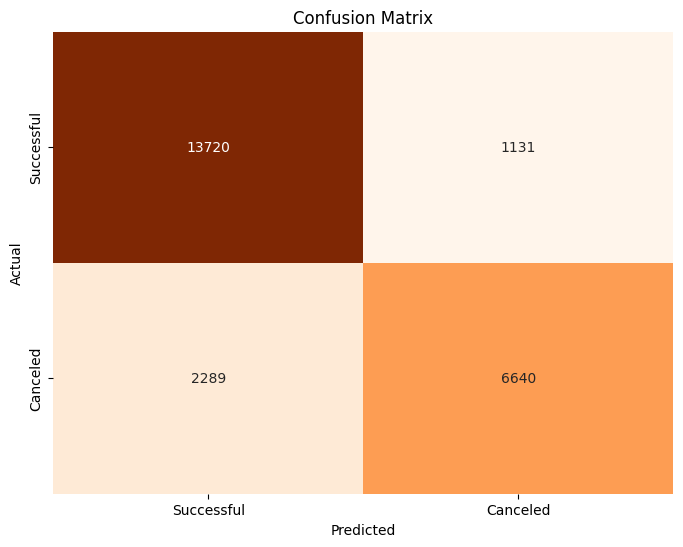

In [64]:
# getting confusion matrix for Neural Network before threshold tuning

# Calculate predictions
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test_nn, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Oranges', cbar = False, 
            xticklabels = ['Successful', 'Canceled'], yticklabels = ['Successful', 'Canceled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

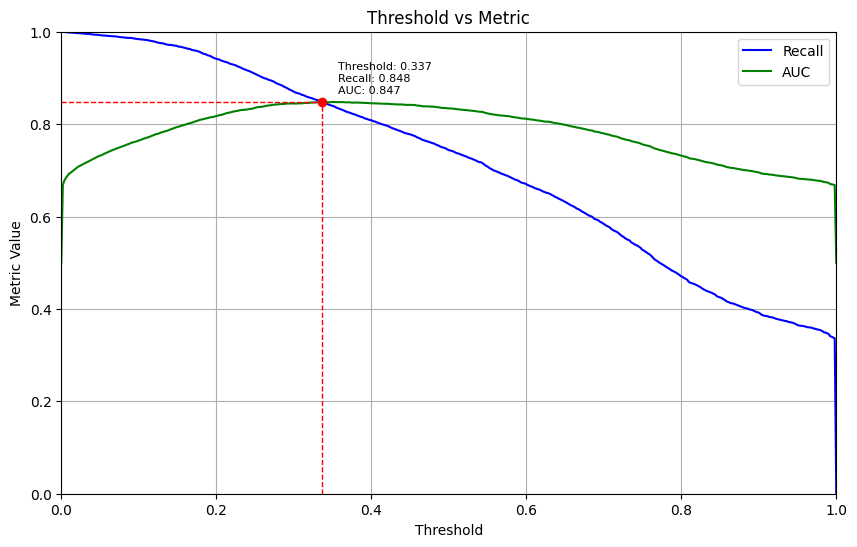

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87     14851
           1       0.77      0.85      0.81      8929

    accuracy                           0.85     23780
   macro avg       0.84      0.85      0.84     23780
weighted avg       0.85      0.85      0.85     23780

Confusion Matrix:


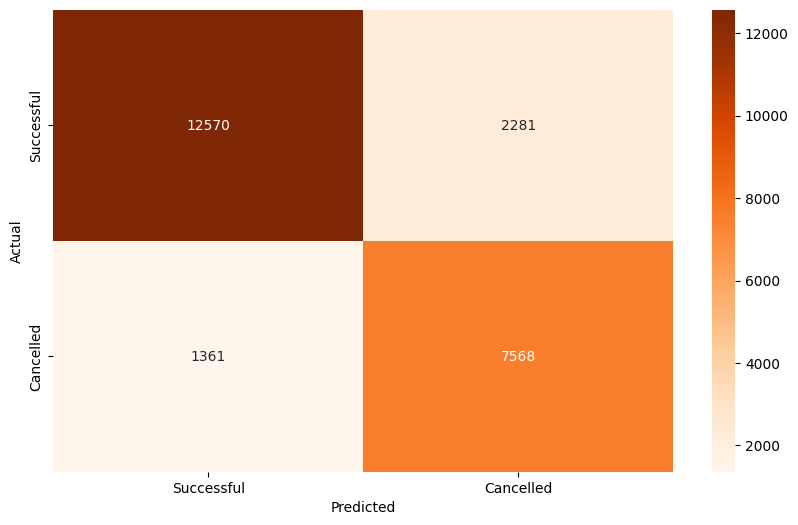

The best threshold is 0.337.
The best recall is 0.848.
The AUC is 0.847.
The F1-score is 0.806.
Business cost is $250150


In [65]:
# Evaluation Metric for 
threshold_nn, recall_nn, auc_nn, f1_nn, business_cost_nn = get_EvalMetrics(model_nn, X_test_preprocessed, y_test_nn)

print(f'The best threshold is {threshold_nn}.')
print(f'The best recall is {recall_nn}.')
print(f'The AUC is {auc_nn}.')
print(f'The F1-score is {f1_nn}.')
print(f'Business cost is ${business_cost_nn}')

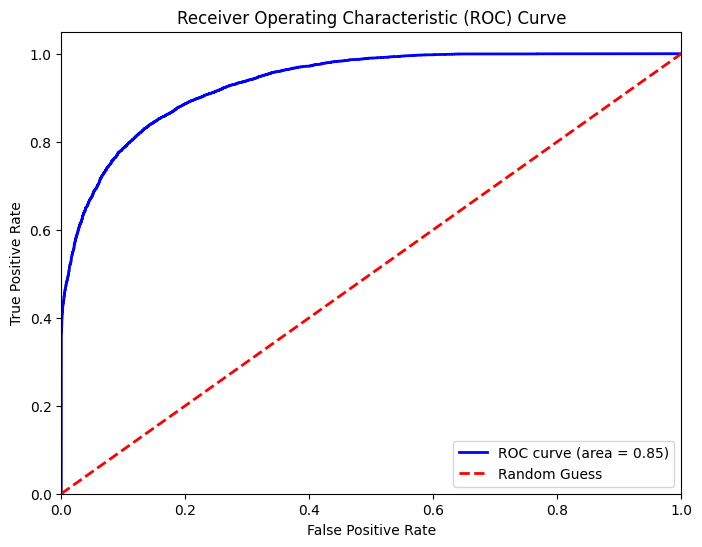

In [66]:
# plotting ROC curve of NN
# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, _ = roc_curve(y_test_nn, y_pred_proba)

# Plot ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = 'blue', lw = 2, label = 'ROC curve (area = %0.2f)' % auc_nn)
plt.plot([0, 1], [0, 1], color = 'red', lw = 2, linestyle = '--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.show()


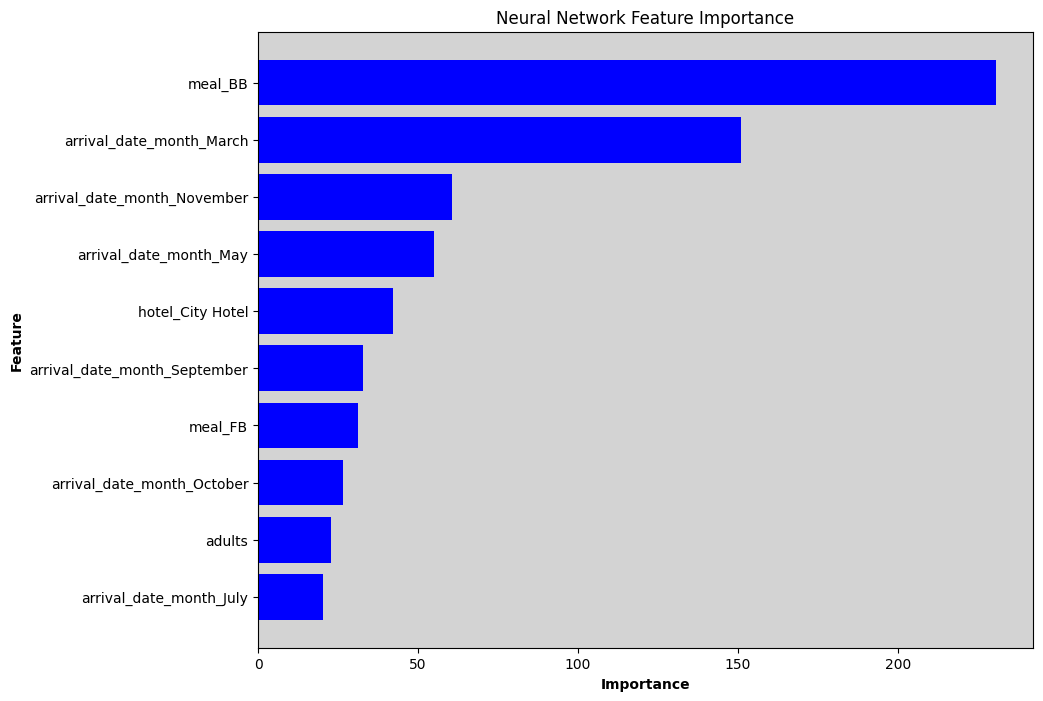

In [67]:
# Getting feature importance for Neural Network

# Get the weights of the first layer (input layer)
input_layer_weights = model_nn.layers[0].get_weights()[0]

# Get the names of categorical features after one-hot encoding
categorical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(input_features = categorical_cols)

# Combine categorical feature names with numerical feature names
all_feature_names = list(categorical_feature_names) + numerical_cols

# Calculate the feature importance as the absolute sum of weights for each feature
feature_importance = np.abs(input_layer_weights).sum(axis = 1)

# Create a DataFrame to display feature importance
feature_importance_df_nn = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df_nn = feature_importance_df_nn.sort_values(by = 'Importance', ascending = False)
top10_nn = feature_importance_df_nn.head(10)

# Plotting feature importance
plt.figure(figsize=(10, 8))
plt.barh(top10_nn['Feature'], top10_nn['Importance'], color='blue')
plt.xlabel('Importance', fontweight = 'bold')
plt.ylabel('Feature', fontweight = 'bold')
plt.title('Neural Network Feature Importance')
plt.gca().set_facecolor('lightgrey')  # Set background color
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

**Model 2: XGB Classifier**

              precision    recall  f1-score   support

           0       0.92      0.80      0.86     15109
           1       0.71      0.89      0.79      8671

    accuracy                           0.83     23780
   macro avg       0.82      0.84      0.82     23780
weighted avg       0.85      0.83      0.83     23780

AUC before threshold tuning is 0.841.


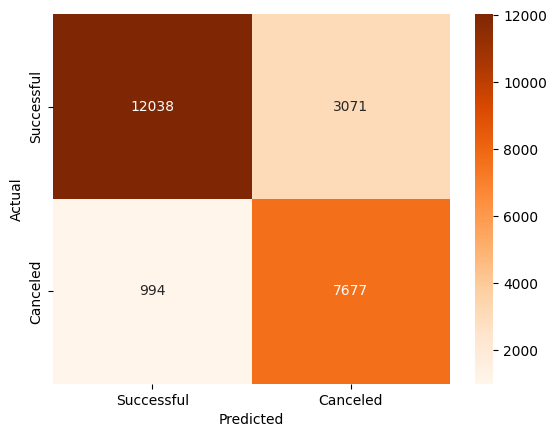

In [68]:
# Getting confusion matrix before threshold tuning
score_model(final_xgb, X_test_scaled, y_test)

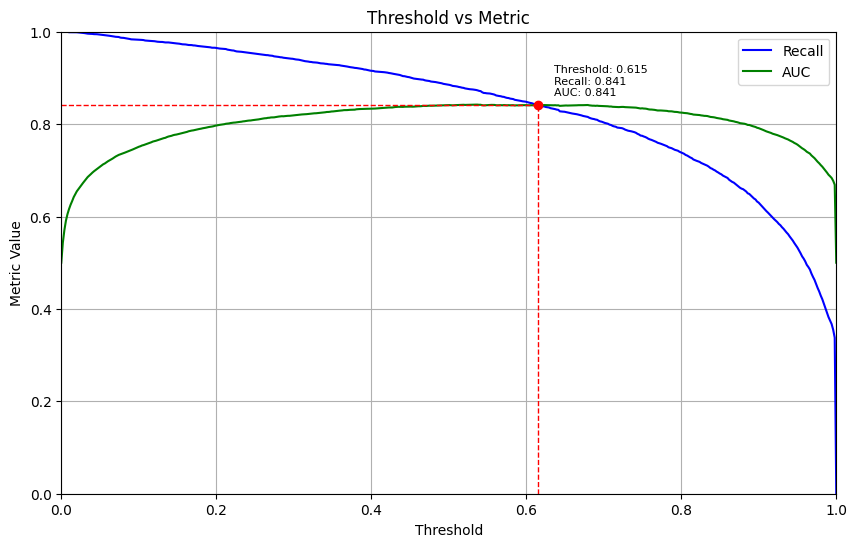

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     15109
           1       0.75      0.84      0.79      8671

    accuracy                           0.84     23780
   macro avg       0.83      0.84      0.83     23780
weighted avg       0.85      0.84      0.84     23780

Confusion Matrix:


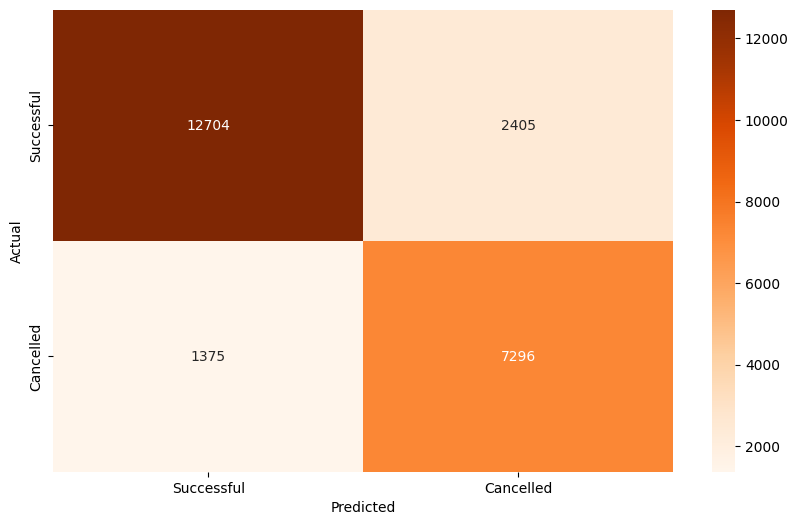

The optimal threshold is 0.615.
The optimal recall is 0.841.
The optimal AUC is 0.841.
The F1-score is 0.794.
Business cost is $257750


In [69]:
# Getting evaluation metrics for XGB after tuning threshold value
threshold_xgb, recall_xgb, auc_xgb, f1_xgb, business_cost_xgb = get_EvalMetrics(final_xgb, X_test_scaled, y_test)

print(f'The optimal threshold is {threshold_xgb}.')
print(f'The optimal recall is {recall_xgb}.')
print(f'The optimal AUC is {auc_xgb}.')
print(f'The F1-score is {f1_xgb}.')
print(f'Business cost is ${business_cost_xgb}')

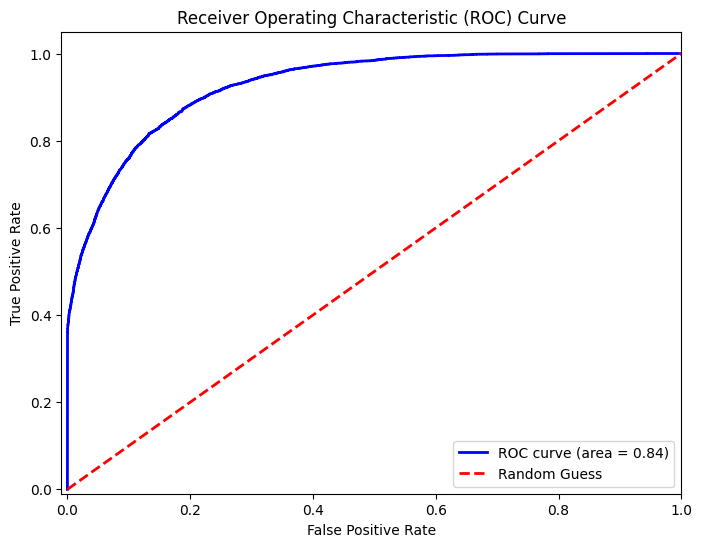

In [70]:
# plot ROC curve
plot_roc(final_xgb, X_test_scaled, y_test, auc_xgb)

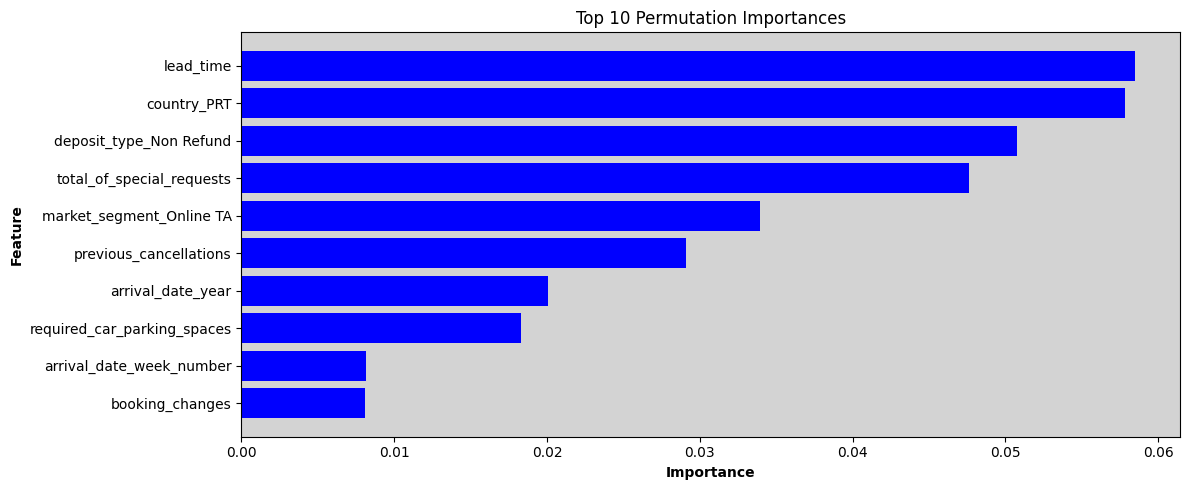

In [71]:
# XGB feature importance
plot_importance(final_xgb, X_test_scaled, y_test)

**Model 3: Random Forest Classifier**

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     15109
           1       0.89      0.65      0.75      8671

    accuracy                           0.84     23780
   macro avg       0.86      0.80      0.82     23780
weighted avg       0.85      0.84      0.84     23780

AUC before threshold tuning is 0.803.


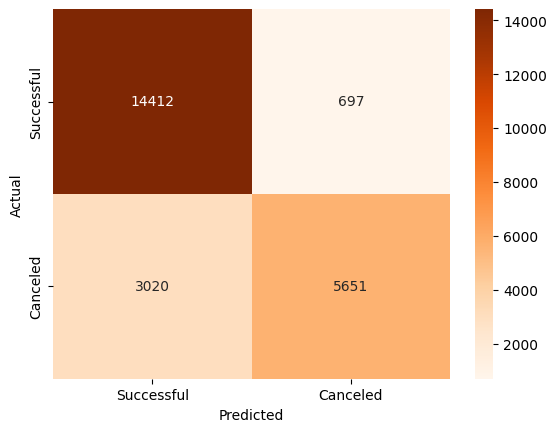

In [72]:
# Confusion Matrix of RF before threshold tuning
score_model(final_rf, X_test_scaled, y_test)

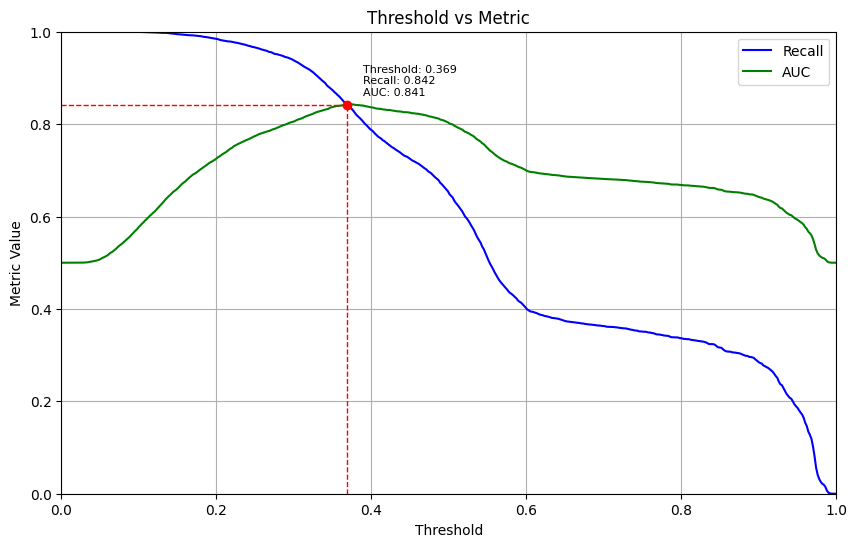

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     15109
           1       0.75      0.84      0.79      8671

    accuracy                           0.84     23780
   macro avg       0.83      0.84      0.83     23780
weighted avg       0.85      0.84      0.84     23780

Confusion Matrix:


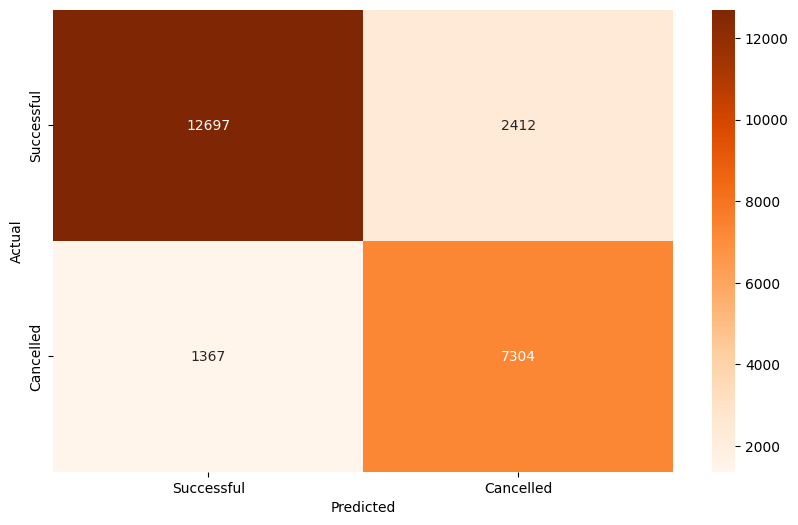

The optimal threshold is 0.369.
The optimal recall is 0.842.
The AUC is 0.841.
The F1-score is 0.794.
The business cost is $257300


In [73]:
# Getting evaluation metrics for RF
threshold_rf, recall_rf, auc_rf, f1_rf, business_cost_rf = get_EvalMetrics(final_rf, X_test_scaled, y_test)

print(f'The optimal threshold is {threshold_rf}.')
print(f'The optimal recall is {recall_rf}.')
print(f'The AUC is {auc_rf}.')
print(f'The F1-score is {f1_rf}.')
print(f'The business cost is ${business_cost_rf}')

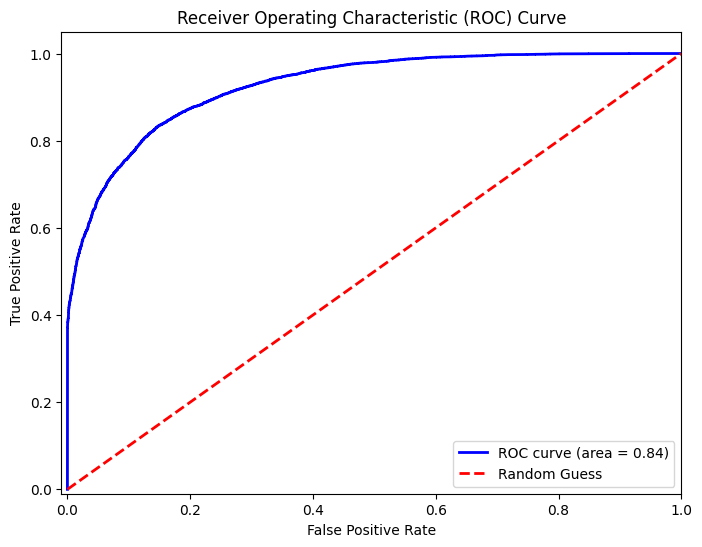

In [74]:
# plotting ROC curve
plot_roc(final_rf, X_test_scaled, y_test, auc_rf)

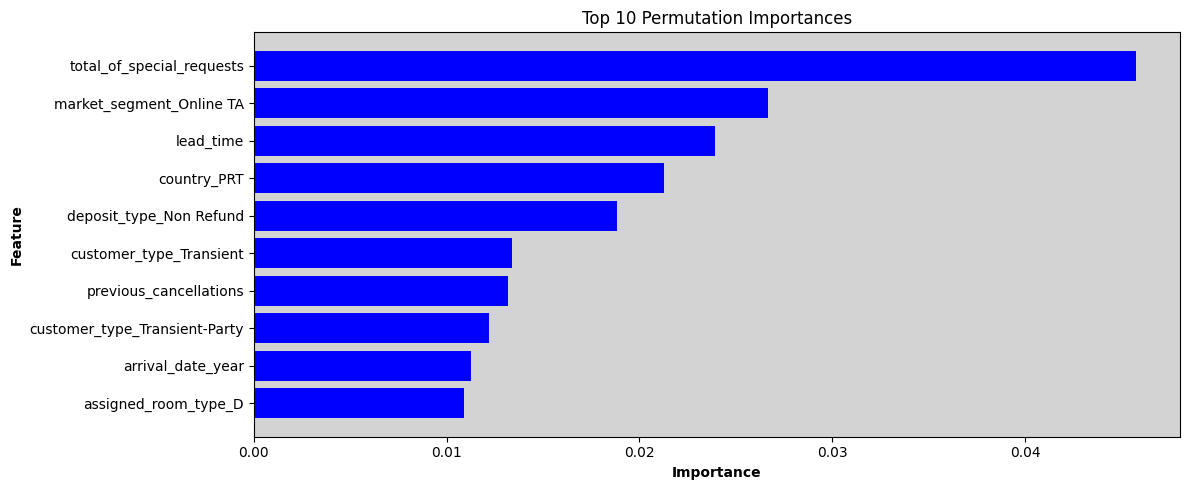

In [75]:
# plotting feature importance
plot_importance(final_rf, X_test_scaled, y_test)

### Model Comparison


In [76]:
# creating a dataframe to compare models
classifiers = ['Neural Network', 'XGBoost', 'Random Forest']
auc_scores = [auc_nn, auc_xgb, auc_rf]
recalls = [recall_nn, recall_xgb, recall_rf]
f1_scores = [f1_nn, f1_xgb, f1_rf]
type2_errors = [1 - recall for recall in recalls]
business_costs = [business_cost_nn, business_cost_xgb, business_cost_rf]

comparison = pd.DataFrame({'Model': classifiers,
                           'AUC': auc_scores,
                           'Recall': recalls,
                           'Type-2 Error': type2_errors,
                           'F1': f1_scores,
                           'Business Cost': business_costs})

comparison = comparison.sort_values(by = ['AUC', 'Recall', 'Business Cost'], ascending = [False, False, True]).reset_index(drop = True)

comparison

,Model,AUC,Recall,Type-2 Error,F1,Business Cost
0,Neural Network,0.847,0.848,0.152,0.806,250150
1,Random Forest,0.841,0.842,0.158,0.794,257300
2,XGBoost,0.841,0.841,0.159,0.794,257750
